In [1]:
from dyeles import DyeLeS
from rdkit import Chem
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
import seaborn as sns

/home/water/miniforge3/envs/DyeLeS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = Path("../data")

coconut_df = pd.read_csv(data_dir / "processed" / "coconut.csv")
dyes_df = pd.read_csv(data_dir / "processed" / "dyes.csv")
zinc_df = pd.read_csv(data_dir / "processed" / "zinc.csv")
npatlas_df = pd.read_csv(data_dir / "processed" / "npatlas.csv")
chembl_df = pd.read_csv(data_dir / "processed" / "chembl.csv")

In [3]:
def build_validation_set(pos_df, neg_df):
    pos_df = pos_df[["smiles"]]
    neg_df = neg_df[["smiles"]]
    min_len = min(len(pos_df), len(neg_df))
    pos_df = pos_df.sample(min_len, random_state=42)
    neg_df = neg_df.sample(min_len, random_state=42)
    pos_df["label"] = 1
    neg_df["label"] = 0
    return pd.concat([pos_df, neg_df])

In [4]:
scorer = DyeLeS()
dyes_zinc_df = build_validation_set(dyes_df, zinc_df)
dyes_zinc_df["score"] = scorer(dyes_zinc_df["smiles"].tolist())

Scoring molecules: 100%|██████████| 52510/52510 [00:22<00:00, 2375.31it/s]


In [5]:
dyes_coconut_df = build_validation_set(dyes_df, coconut_df)
dyes_coconut_df["score"] = scorer(dyes_coconut_df["smiles"].tolist())

Scoring molecules:   0%|          | 0/52510 [00:00<?, ?it/s]

Scoring molecules: 100%|██████████| 52510/52510 [00:25<00:00, 2026.27it/s]


In [6]:
dyes_npatlas_df = build_validation_set(dyes_df, npatlas_df)
dyes_npatlas_df["score"] = scorer(dyes_npatlas_df["smiles"].tolist())

Scoring molecules:   0%|          | 0/52510 [00:00<?, ?it/s]

Scoring molecules: 100%|██████████| 52510/52510 [00:26<00:00, 1994.02it/s]


In [7]:
dyes_chembl_df = build_validation_set(dyes_df, chembl_df)
dyes_chembl_df["score"] = scorer(dyes_chembl_df["smiles"].tolist())

Scoring molecules: 100%|██████████| 52510/52510 [00:25<00:00, 2065.02it/s]


In [8]:
def _plot_auc_roc(y_true: list, y_pred: list, label: str, ax: plt.Axes, color: str):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})", color=color, alpha=0.8)

In [9]:
colors = plt.cm.Set2.colors

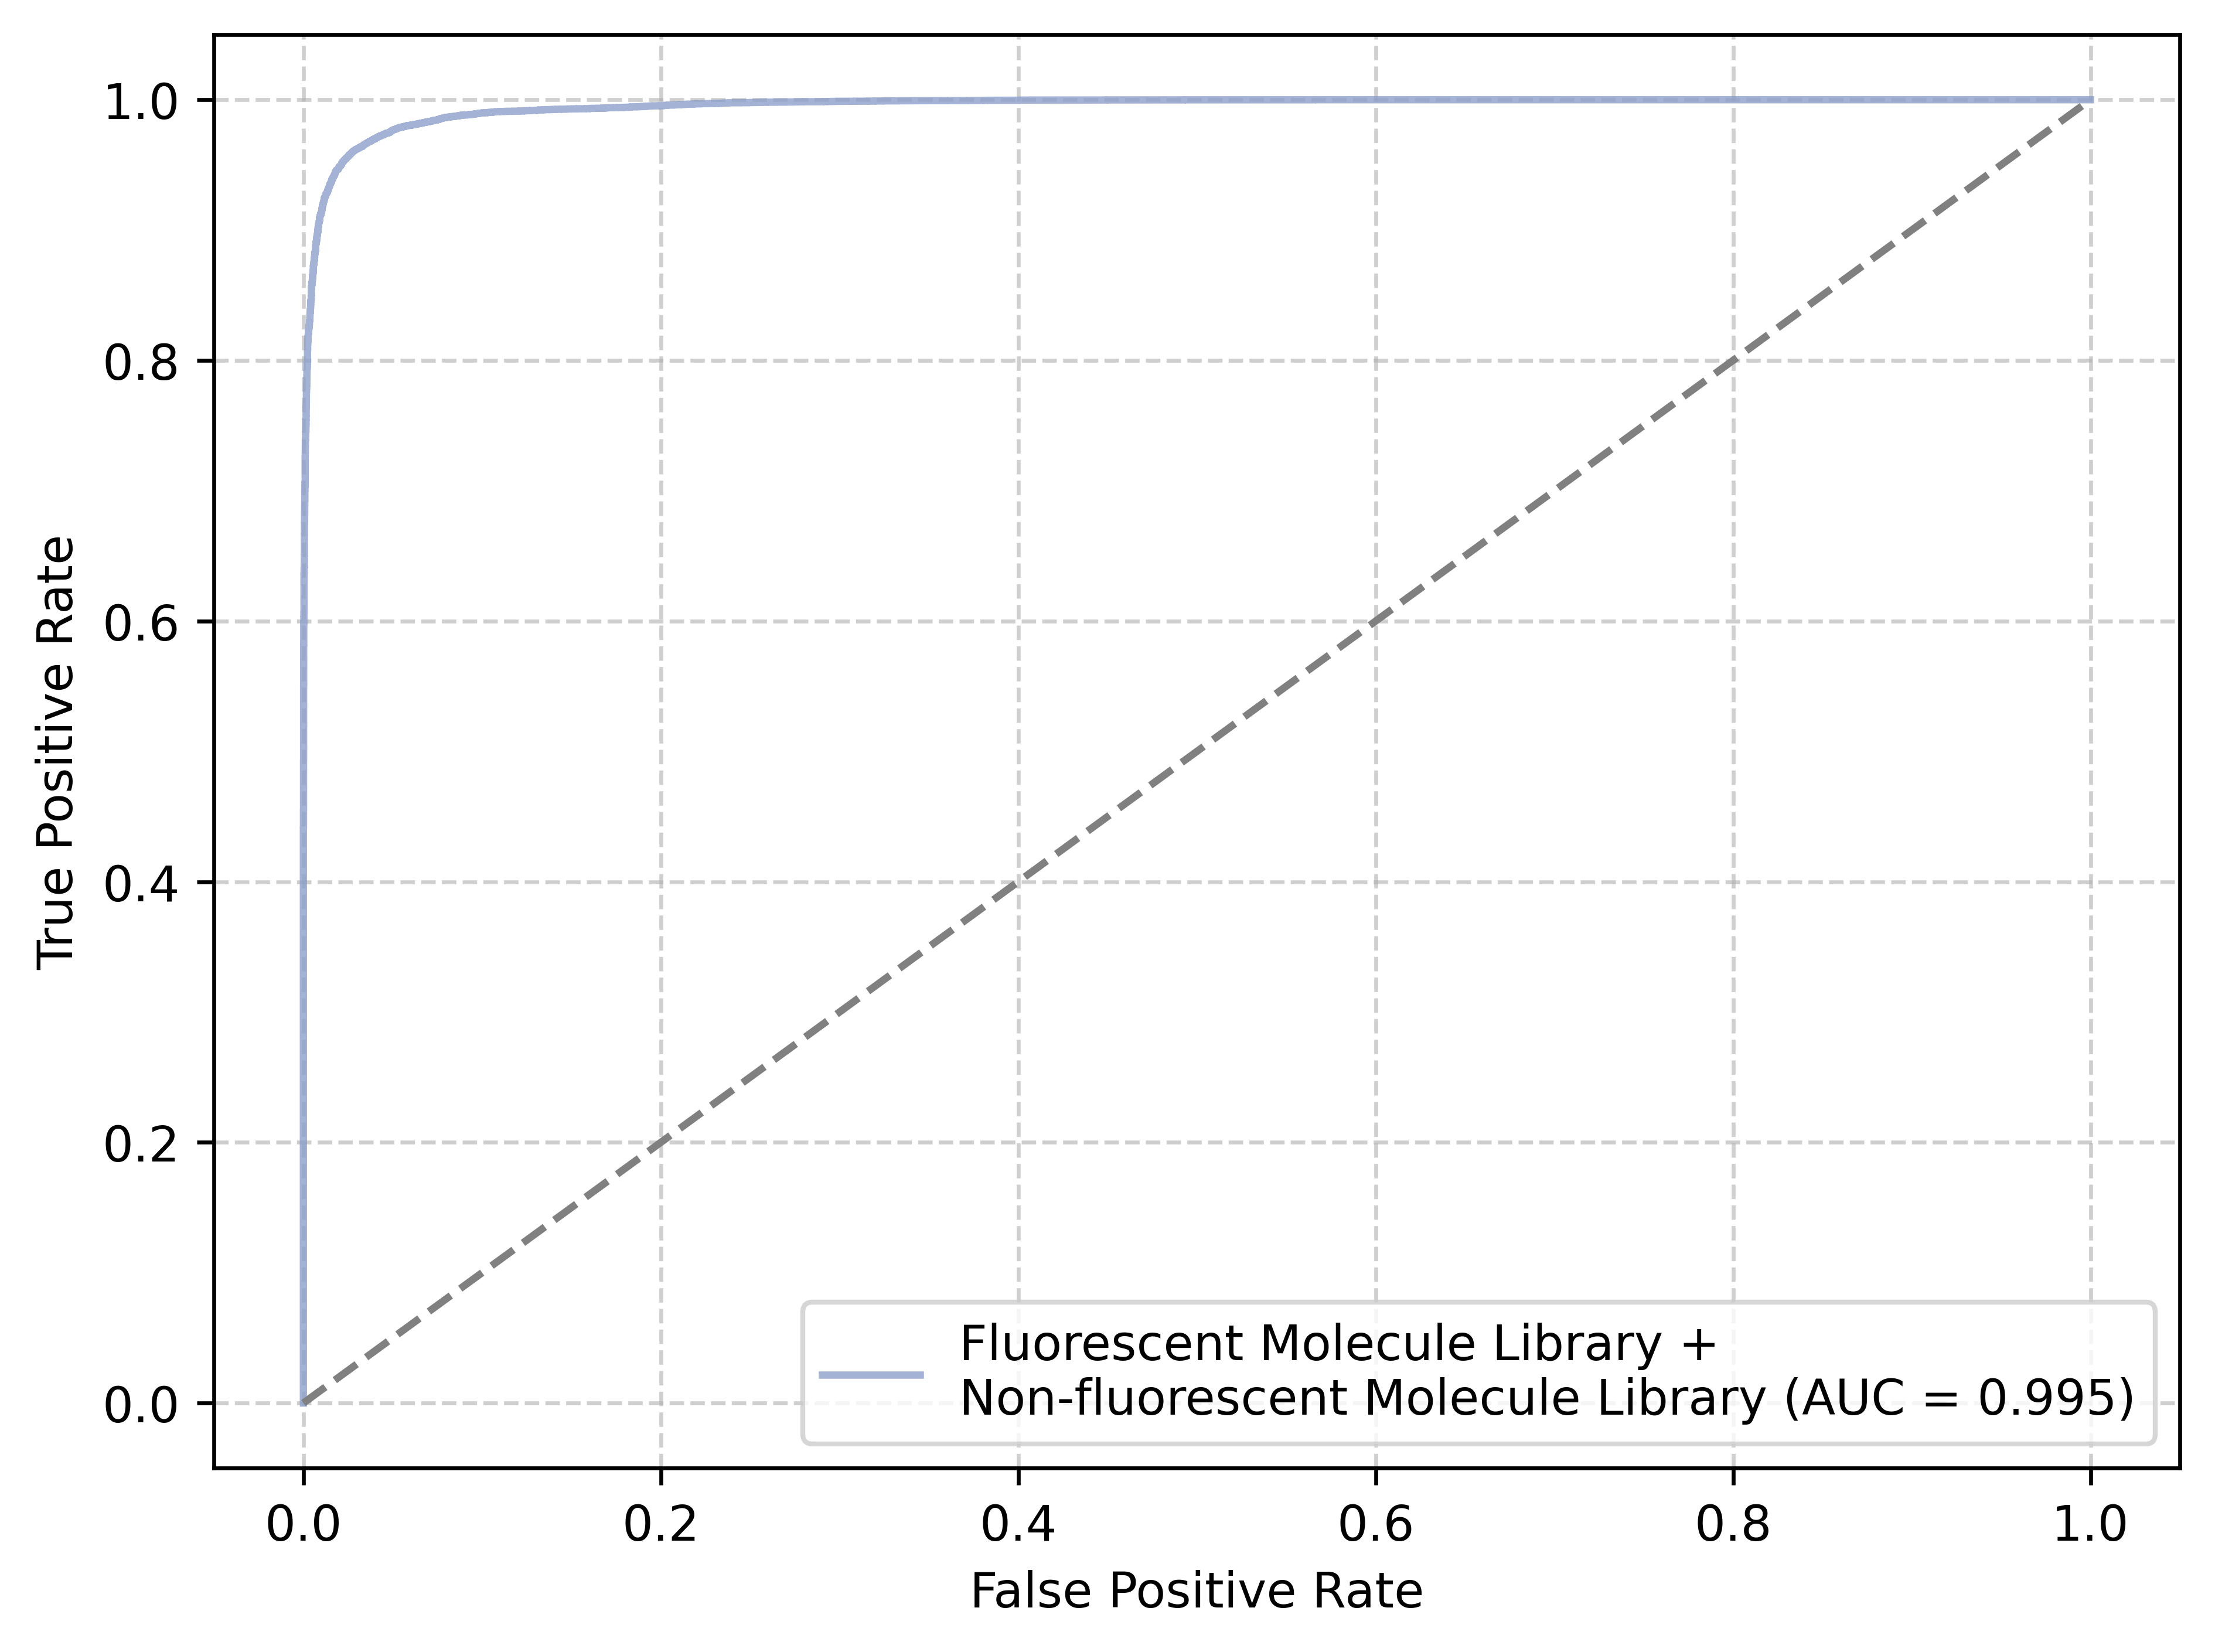

In [14]:
fig, ax = plt.subplots(dpi=600)
_plot_auc_roc(dyes_coconut_df.label.tolist(), dyes_coconut_df.score.tolist(), "Fluorescent Molecule Library + \nNon-fluorescent Molecule Library", ax, colors[2])


plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # 随机线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

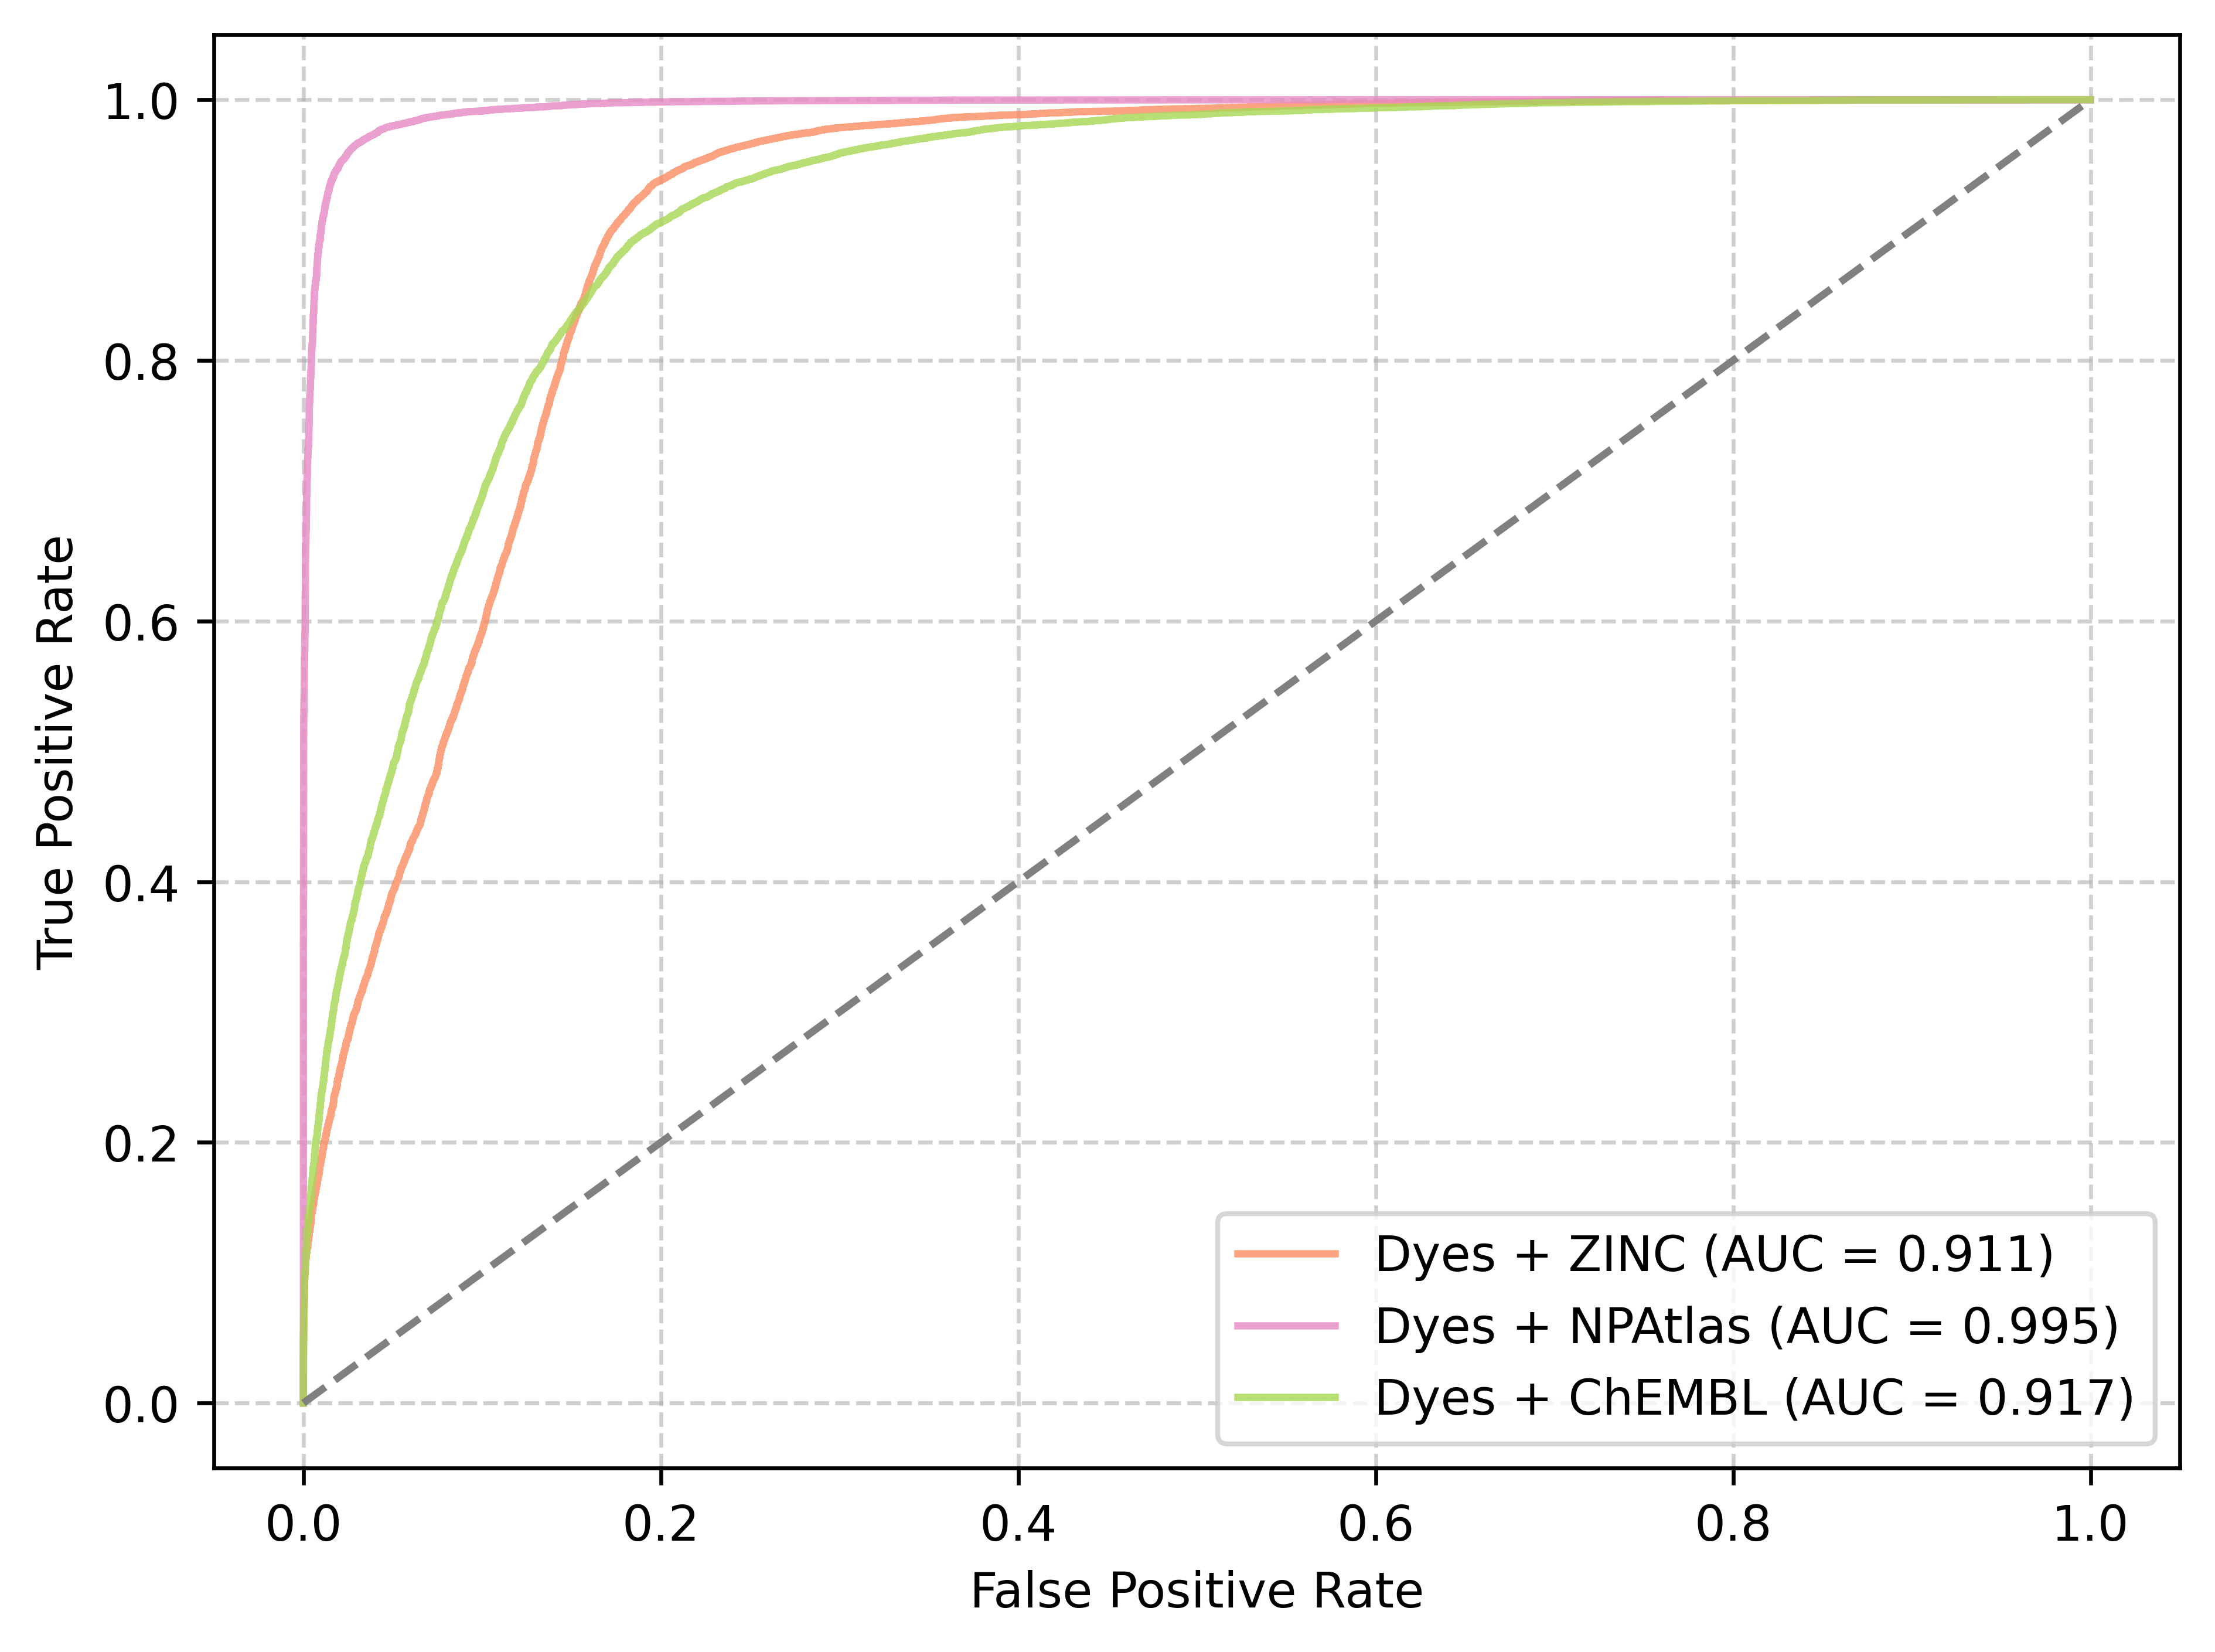

In [15]:
fig, ax = plt.subplots(dpi=600)
_plot_auc_roc(dyes_zinc_df.label.tolist(), dyes_zinc_df.score.tolist(), "Dyes + ZINC", ax, colors[1])
_plot_auc_roc(dyes_npatlas_df.label.tolist(), dyes_npatlas_df.score.tolist(), "Dyes + NPAtlas", ax, colors[3])
_plot_auc_roc(dyes_chembl_df.label.tolist(), dyes_chembl_df.score.tolist(), "Dyes + ChEMBL", ax, colors[4])

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # 随机线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

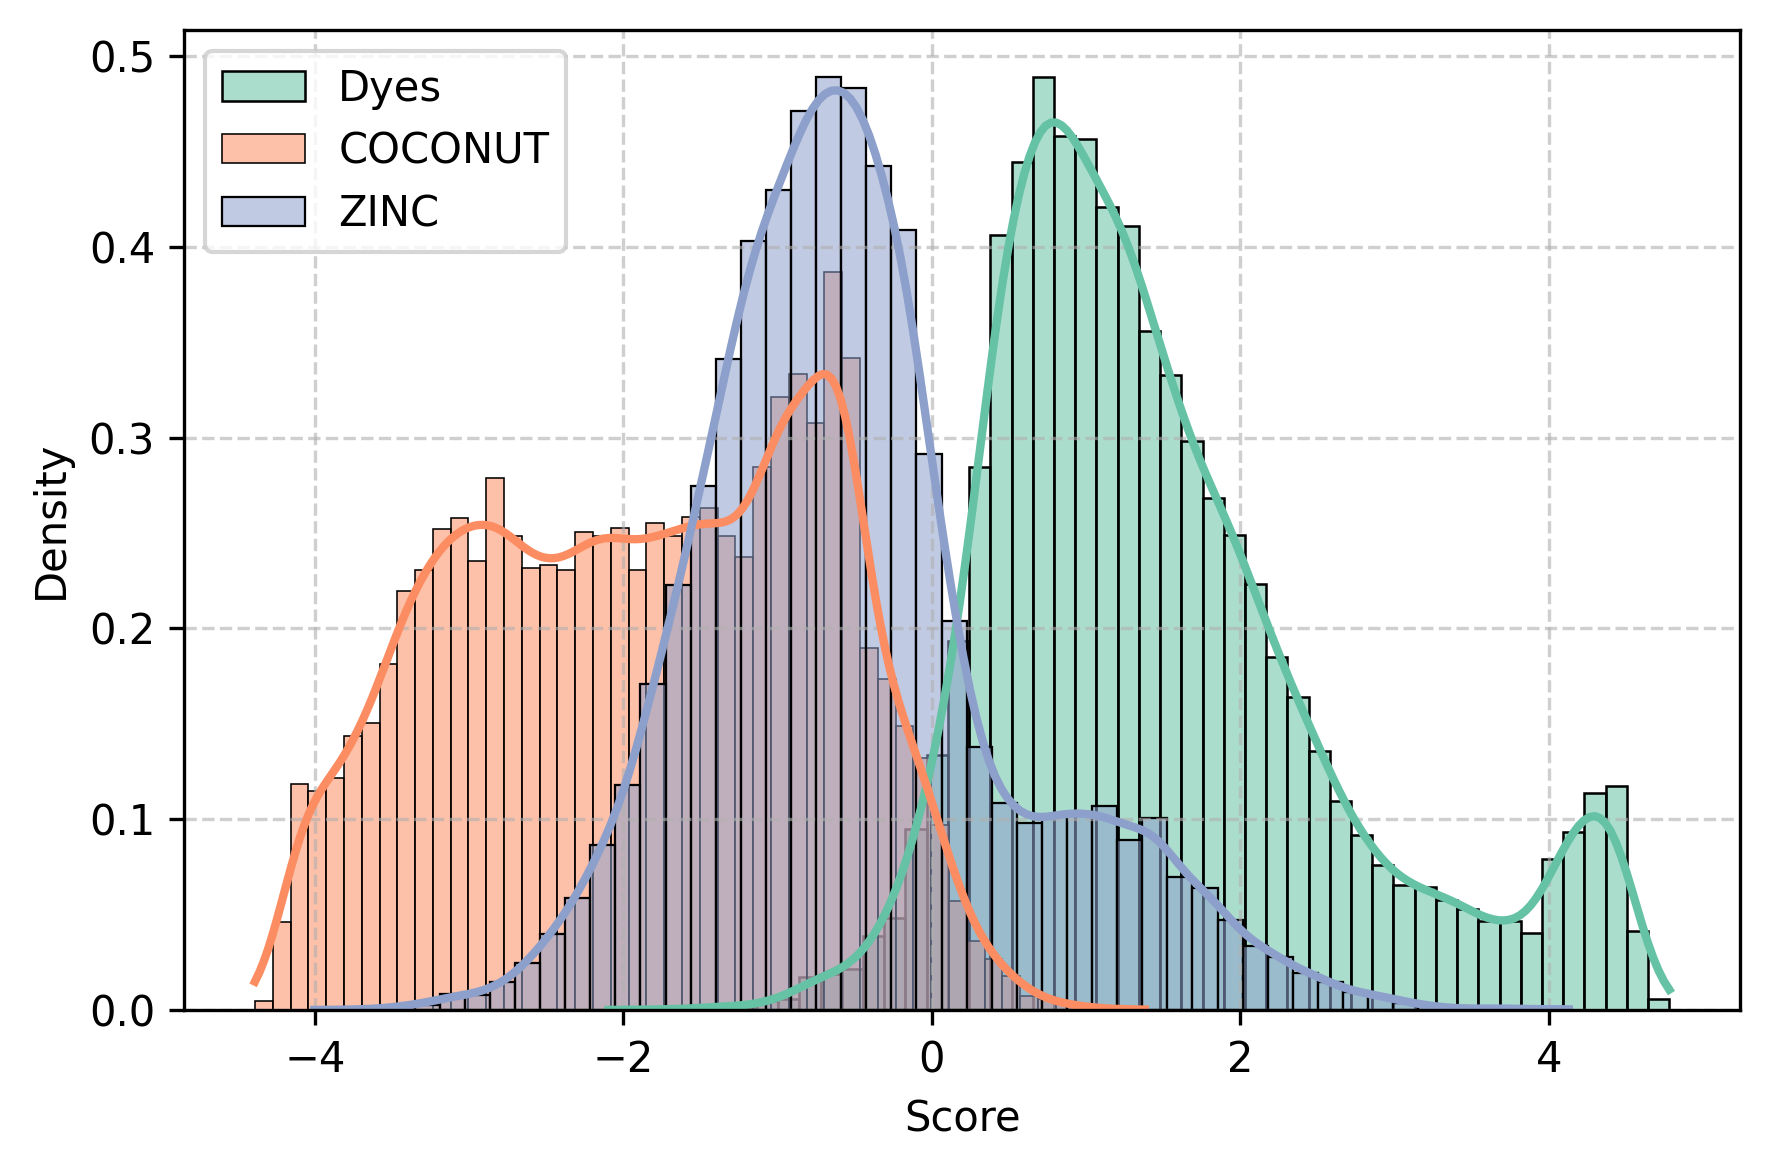

In [19]:
# 1) 一行提取 + 去掉 NaN
score_dict = {
    "Dyes"   : dyes_coconut_df .loc[dyes_coconut_df .label == 1, "score"].dropna(),
    "COCONUT": dyes_coconut_df .loc[dyes_coconut_df .label == 0, "score"].dropna(),
    "ZINC"   : dyes_zinc_df    .loc[dyes_zinc_df    .label == 0, "score"].dropna(),
}

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

for (name, scores), color in zip(score_dict.items(), colors):
    # 2) 用 seaborn.histplot 直接叠加 KDE，stat='density' 让直方图与 KDE 同单位
    sns.histplot(
        scores,
        bins=50,
        stat="density",      # 关键：让直方图 y 轴 = 概率密度
        kde=True,
        line_kws={"linewidth": 2},
        color=color,
        edgecolor="black",
        alpha=0.55,
        label=name,
        ax=ax
    )

ax.set(xlabel="Score", ylabel="Density")
ax.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

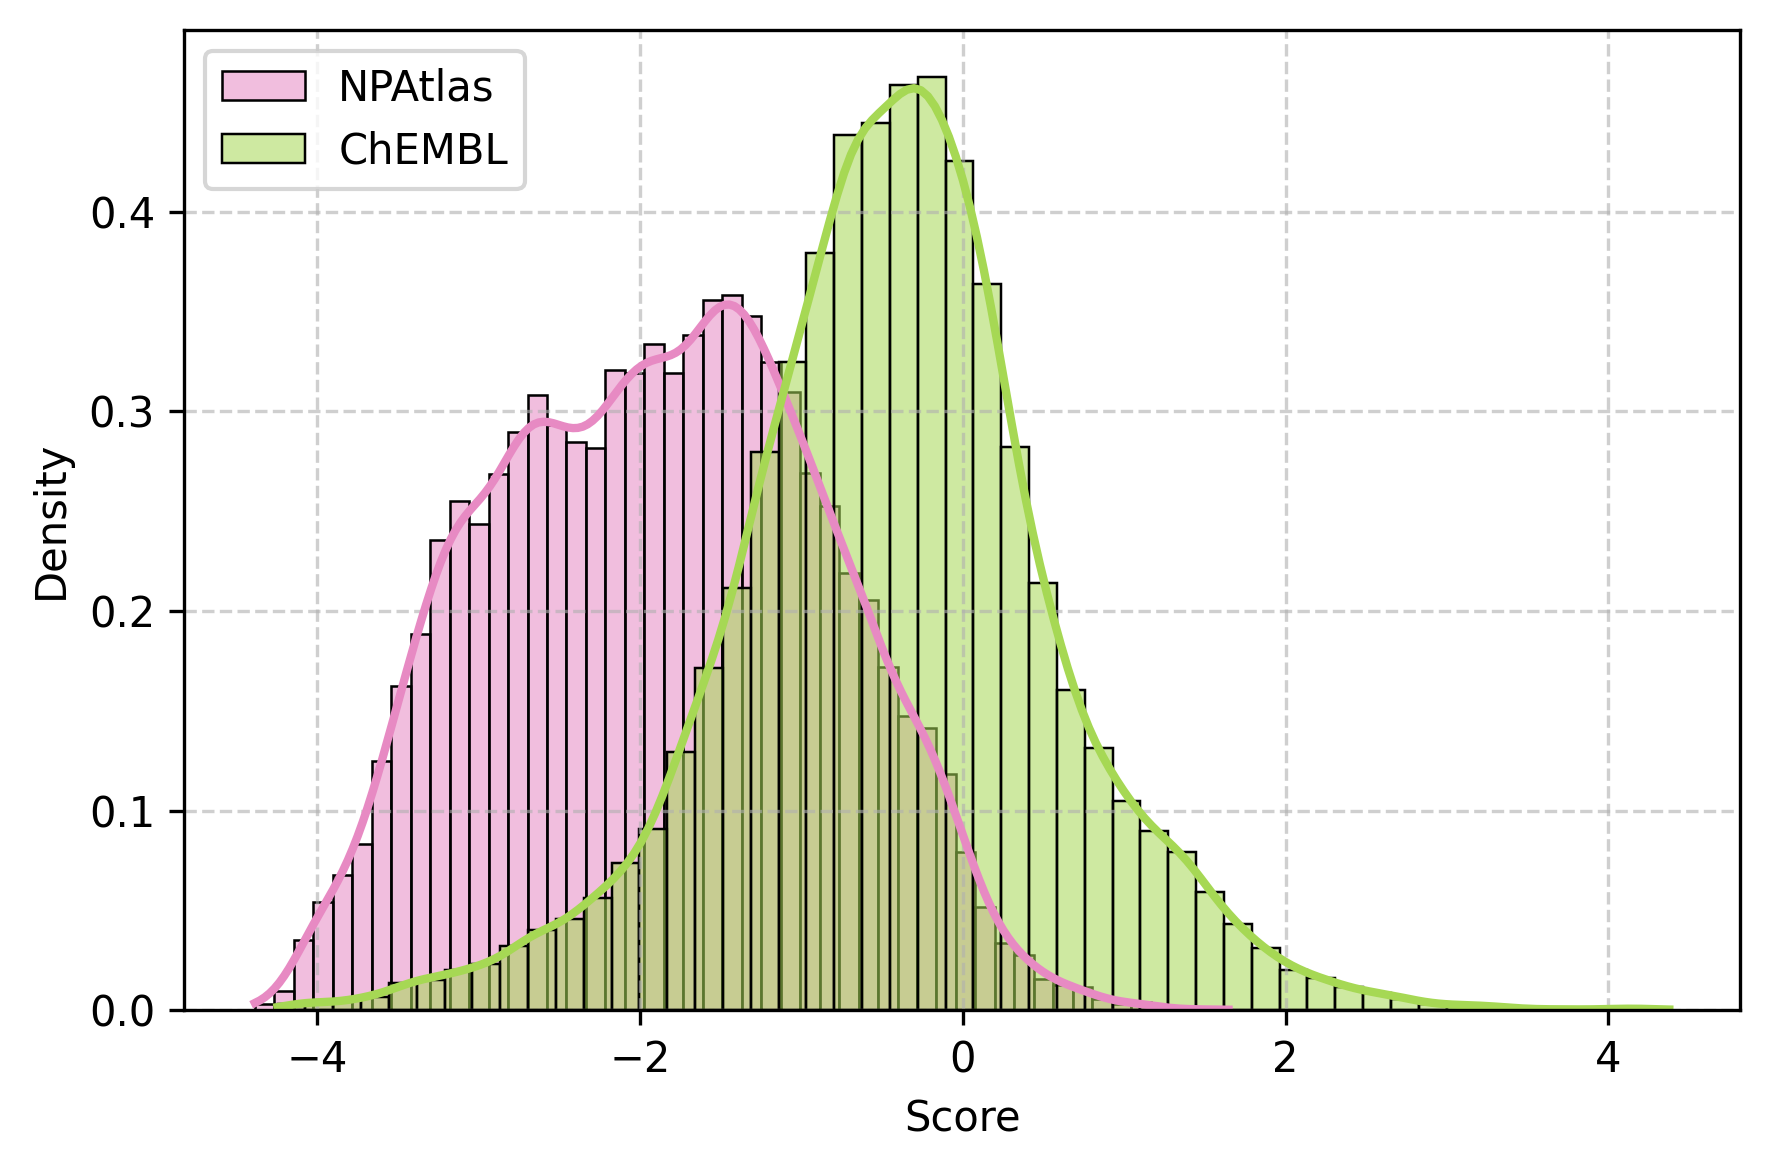

In [18]:
# 1) 一行提取 + 去掉 NaN
score_dict = {
    "NPAtlas": dyes_npatlas_df .loc[dyes_npatlas_df .label == 0, "score"].dropna(),
    "ChEMBL" : dyes_chembl_df .loc[dyes_chembl_df .label == 0, "score"].dropna(),
}

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

for (name, scores), color in zip(score_dict.items(), colors[3:]):
    # 2) 用 seaborn.histplot 直接叠加 KDE，stat='density' 让直方图与 KDE 同单位
    sns.histplot(
        scores,
        bins=50,
        stat="density",      # 关键：让直方图 y 轴 = 概率密度
        kde=True,
        line_kws={"linewidth": 2},
        color=color,
        edgecolor="black",
        alpha=0.55,
        label=name,
        ax=ax
    )

ax.set(xlabel="Score", ylabel="Density")
ax.legend(loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()